# San Diego Get It Done (311)

This lesson does:

- Load one CSV
- Clean core fields
- Exploratory analysis (volumes, top services, durations)
- A light regression to predict **days to close** (log-transformed), with clear metrics

**Tip:** Download: Open Data → *Reports of non-emergency problems submitted by users of Get It Done* →
resource **Get It Done Requests closed in 2025** (CSV). Save locally and update `CSV_PATH` below.


<img src="https://cal-icor.github.io/textbook.data/ucb/jupyter-con/sd-skyline.jpg" alt="San Diego Skyline"/>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

## 1) Load one CSV
We only load a single file. The expected columns include:
`service_request_id`, `service_name`, `status`, `date_requested`, `date_closed`,
`case_record_type`, `zipcode`, `council_district`, `latitude`, `longitude` (some may vary).

In [2]:
cols = [
    "service_request_id","service_name","status","date_requested","date_closed",
    "case_record_type","zipcode","council_district","latitude","longitude","neighborhood"
]
# Read robustly: ignore extra columns, parse dates where present
df = pd.read_csv("https://cal-icor.github.io/textbook.data/ucb/jupyter-con/get_it_done_requests_closed_2025.csv", 
                 parse_dates=["date_requested","date_closed"], low_memory=False)
# Standardize column names (lower + underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
# Keep intersection with expected
keep = [c for c in cols if c in df.columns]
df = df[keep].copy()
print("Loaded shape:", df.shape)
display(df.head(3))

Loaded shape: (317421, 8)


,service_request_id,service_name,status,date_requested,date_closed,case_record_type,zipcode,council_district
0,104196,Parks Issue,Closed,2016-09-08 08:48:00,2025-09-30,Parks & Recreation,92109.0,1.0
1,107425,Pavement Maintenance,Closed,2016-09-22 11:59:00,2025-04-15,TSW,NaN,3.0
2,111231,Pavement Maintenance,Closed,2016-10-10 21:26:00,2025-08-08,TSW,NaN,3.0


## 2) Basic cleaning & features
- Keep only rows with a requested date
- Compute `days_to_close` (if status is Closed and we have close date)
- Extract calendar features for simple analyses

In [3]:
df = df[df["date_requested"].notna()].copy()

# duration
if "date_closed" in df.columns:
    dur = (df["date_closed"] - df["date_requested"]).dt.total_seconds() / 86400.0
    df["days_to_close"] = dur
else:
    df["days_to_close"] = np.nan

# clip negatives and extreme nonsense
df["days_to_close"] = df["days_to_close"].clip(lower=0)

# calendar
dt = df["date_requested"]
df["req_year"] = dt.dt.year
df["req_month"] = dt.dt.month
df["req_dow"] = dt.dt.dayofweek  # 0=Mon
df["req_hour"] = dt.dt.hour
df["is_weekend"] = df["req_dow"].isin([5,6]).astype(int)

print("After cleaning:", df.shape)

After cleaning: (317421, 14)


## 3) Exploratory Analysis
### 3.1 Requests per month
*(Interactive line chart)*

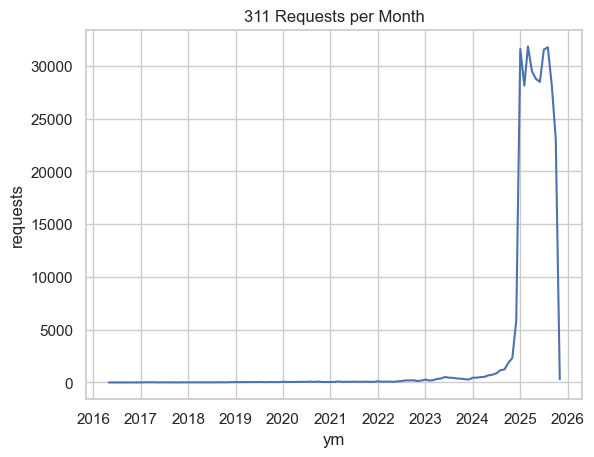

In [4]:
monthly = (
    df.assign(ym=lambda x: x["date_requested"].dt.to_period("M").dt.to_timestamp())
      .groupby("ym", as_index=False)
      .agg(requests=("service_request_id","count"))
)
fig = sns.lineplot(data=monthly, x="ym", y="requests")
fig.set_title("311 Requests per Month")
fig;

### 3.2 Top service types
*(Interactive bar chart)*

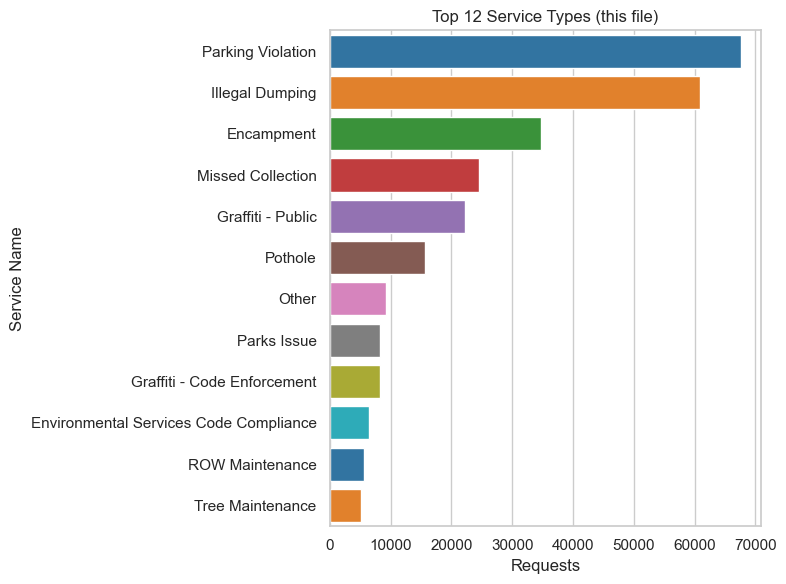

In [5]:
top_types = (
    df["service_name"].astype("string").str.strip().value_counts().head(12)
      .rename_axis("service_name").reset_index(name="n")
)
plot_data = top_types.sort_values("n", ascending=False)
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=plot_data, x="n", y="service_name", hue="service_name", dodge=False, palette="tab10", ax=ax)
if ax.legend_:
    ax.legend_.remove()
ax.set_title("Top 12 Service Types (this file)")
ax.set_xlabel("Requests")
ax.set_ylabel("Service Name")
plt.tight_layout()
plt.show()

### 3.3 How long do things take to close?
We look at the distribution for **Closed** rows only, if present.

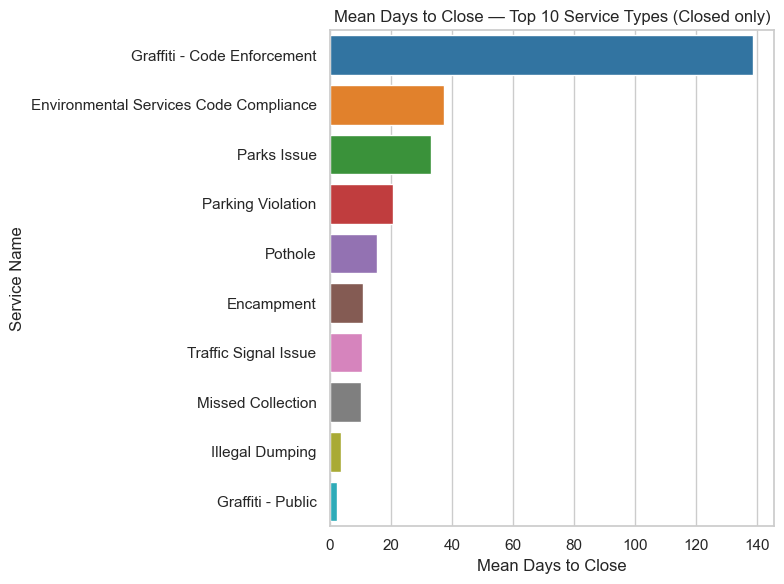

In [6]:
if "status" in df.columns:
    closed = df[(df["status"].astype(str).str.title() == "Closed") & df["days_to_close"].notna()].copy()
    if len(closed):
        by_type = (
            closed.groupby("service_name", as_index=False)
                  .agg(n=("service_request_id","count"),
                       mean_days=("days_to_close","mean"),
                       p50=("days_to_close","median"))
                  .sort_values("n", ascending=False).head(10)
        )
        plot_data = by_type.sort_values("mean_days", ascending=False)
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.barplot(data=plot_data, x="mean_days", y="service_name", hue="service_name", dodge=False, palette="tab10", ax=ax)
        if ax.legend_:
            ax.legend_.remove()
        ax.set_title("Mean Days to Close — Top 10 Service Types (Closed only)")
        ax.set_xlabel("Mean Days to Close")
        ax.set_ylabel("Service Name")
        plt.tight_layout()
        plt.show()
    else:
        print("No closed rows with durations — skipping turnaround chart.")
else:
    print("No 'status' column — skipping closed/turnaround charts.")

## Conclusion

Through this exploratory data analysis, we gained several insights about San Diego’s Get It Done 311 service requests. Usage of the system has grown rapidly – residents are increasingly turning to the app/website to report issues, resulting in hundreds of thousands of requests per year. The most common complaints involve everyday city maintenance and enforcement issues: parking violations, graffiti, potholes, illegal dumping, and homeless encampments are at the forefront. This aligns with city priorities in keeping streets safe and clean. The analysis of response times shows that while many issues are addressed in a timely manner (a few days to a week for most service types), certain problems – especially those requiring longer-term solutions or inter-departmental coordination – take longer and can lead to frustration when marked “closed” without resolution.

Overall, data analysis like this can help the City of San Diego improve its services. Knowing which issues generate the most reports can guide resource allocation (for example, dedicating more crews to fix potholes or clean graffiti in hot-spot areas). Understanding resolution times and where delays occur can highlight process improvements – the City has already initiated changes such as providing better status updates to users and exploring options like a centralized 311 call system. As San Diego continues to expand the Get It Done program (including new features like multilingual support and user feedback surveys), ongoing analysis of the 311 data will be valuable. By regularly monitoring the data, the City can track its performance, identify emerging issues (for instance, a sudden spike in water pipe break reports), and ensure that it continues to respond effectively to the needs of its residents.

Sources:
- 	City of San Diego Open Data Portal – Get It Done Service Requests Dataset ￼ ￼
-	City of San Diego Inside San Diego news blog – “Get It Done Celebrates Successes” (May 23, 2024) ￼ ￼
-	San Diego City Auditor Report (2022) – via San Diego Union-Tribune summary ￼ ￼
-	San Diego Regional Data Library – Get It Done Data Dictionary ￼ ￼